In [158]:
# find out what Amazon does with my tasks are distrubuted across WHICH containers

# %pylab inline
import pywren
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_style('whitegrid')
import os
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from itertools import count
#########################
from bokeh.core.properties import value
from bokeh.io import output_notebook, show, push_notebook
import bokeh.plotting.figure
from bokeh.models import ColumnDataSource, HoverTool, WheelZoomTool
output_notebook()

Loading BokehJS ...

In [91]:
# run pywren
def my_function(key):
    import time
    time.sleep(20)
    return key

pwex = pywren.default_executor()
futures1 = pwex.map(my_function, range(1000))
pywren.wait(futures1)

#futures2 = pwex.map(my_function, range(1000))
pywren.wait(futures2)

([<pywren.future.ResponseFuture at 0x10e27cb00>,
 [])

In [191]:
# collect info from pywren futures
def collect_execution_info(futures):
    results = [f.result() for f in futures]
    run_statuses = [f.run_status for f in futures]
    invoke_statuses = [f.invoke_status for f in futures]
    # need to analyze both run_statuses and invoke_statuses
#    print(invoke_statuses)
    return {'results' : results,'run_statuses' : run_statuses, 'invoke_statuses' : invoke_statuses}

info = collect_execution_info(futures1 + futures2)

Max concurrency frequencies (blue): {1: 1, 2: 323, 3: 24, 4: 25, 5: 19, 6: 31, 7: 17, 8: 42, 9: 9, 10: 1, 11: 1}
IP use frequencies (red): {1: 1, 2: 305, 3: 17, 4: 15, 5: 11, 6: 23, 7: 20, 8: 31, 9: 17, 10: 42, 11: 9, 12: 1, 13: 1}
Unique IP count: 493


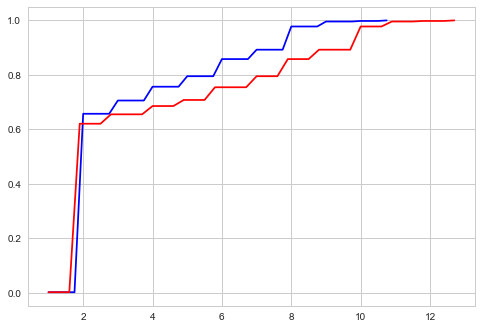

In [209]:
def get_list_of_maxes(fields, jobIDs, unames):
    
    # tuple with (jobID, IP, starting time, ending time)
    precompiled = [(int(jobID),
              unames[int(jobID)],
              fields[0][1][int(jobID)],
              fields[0][1][int(jobID)] + fields[1][1][int(jobID)] + fields[2][1][int(jobID)] + fields[3][1][int(jobID)] + fields[4][1][int(jobID)])
             for jobID in jobIDs]
    
    # a dictionary of all the IPs and the jobs using it 
    jobsByIP = {}
    for job in precompiled:
        if (job[1] in jobsByIP):
            jobsByIP[job[1]].append(job)
        else:
            jobsByIP[job[1]] = [job]
    
    # a dictionary with all the IPs and their max concurrent jobs running
    max_concurrent = {}
    for IP in jobsByIP:
        jobs = jobsByIP[IP]

        event_points = []
        concurrent_now = 0
        maximum_concurrent = 0
        for job in jobs:
            # start point
            event_points.append((job[2], 1)) 
            #end point
            event_points.append((job[3], -1)) 

        # Python sorts a list of tuples by comparing the first element of each tuple
        # which is the event time.
        event_points.sort()
        for i in event_points:
            concurrent_now += i[1]
            maximum_concurrent = max(concurrent_now, maximum_concurrent)

        # finds the max concurrent for an IP
        max_concurrent[IP] = maximum_concurrent
    list_of_maxes = list(max_concurrent.values())
    
    return list_of_maxes
    
def plot_cdfs(list_of_maxes, list_of_IP_uses):
    # prints details about distributions
    IP_use_freq = dict((x, list_of_IP_uses.count(x)) for x in set(list_of_IP_uses))
    max_concurrency_freq = dict((x, list_of_maxes.count(x)) for x in set(list_of_maxes))
    print("Max concurrency frequencies (blue): " + str(max_concurrency_freq))
    print("IP use frequencies (red): " + str(IP_use_freq))
    print("Unique IP count: " + str(len(list_of_maxes)))
    
    # plot the CDF for max_concurrency
    data = list_of_maxes
    values, base = np.histogram(data, bins=40)
    cumulative = np.cumsum(values) / len(list_of_maxes)
    plt.plot(base[:-1], cumulative, c='blue')
    
    # plot the CDF for IP_uses
    data2 = list_of_IP_uses
    values, base = np.histogram(data2, bins=40)
    cumulative2 = np.cumsum(values) / len(list_of_IP_uses)
    plt.plot(base[:-1], cumulative2, c='red')


    plt.show()
    
def plot_bokeh(unames_jobID, fields):
    # set up data sources
    stages = ["time to submit to host", "time to start job", "time to finish setup", "time to finish job", "time to return results"]
    data = {'host ID' : unames_jobID,
            #'jobIDs' : jobIDs,
            'time to submit to host' : list(fields[0][1]),
            'time to start job' : list(fields[1][1]),
            'time to finish setup' : list(fields[2][1]),
            'time to finish job' : list(fields[3][1]),
            'time to return results' : list(fields[4][1])}
    
    # should change colors
    # try to make first bar transparent
#    colors = ["#ffffff", "#ffccff", "#ff99ff", "#ff66ff", "#ff33ff"]
#    colors = ["#33ff00", "#330055", "#33ff00", "#330055", "#33ff00"]
    colors = ["#ffffff", "#00ff00", "#0000ff", "#800080", "#000000"]

    # plot structure
    # auto enabled wheel_zoom, but should be 'xwheel_zoom' ALSO
    p = bokeh.plotting.figure(y_range=unames_jobID, plot_height=400, plot_width=800, x_range=(-15, 70),
                              title="Pywren Execution GANTT Chart", active_scroll = 'wheel_zoom')

    # plot contents
    stacked = p.hbar_stack(stages, y='host ID', height=0.9, color=colors, source=ColumnDataSource(data),
                 legend=[value(x) for x in stages])

    # plot details
    # in order to get xwheel_zoom, scroll over the x axis; this is not intuitive
    p.legend.location = "top_left"
    p.xaxis.axis_label = "Wallclock Time (sec)"
    p.yaxis.axis_label = "Host ID (reuse #) {Task ID}"
    hover = bokeh.models.HoverTool(tooltips=[("host ID", "@{host ID}"),
                                             ("host submit delta", "@{time to submit to host}"),
                                             ("job start delta", "@{time to start job}"),
                                             ("setup done delta", "@{time to finish setup}"),
                                             ("job done delta", "@{time to finish job}"),
                                             ("results returned delta", "@{time to return results}")])
    p.add_tools(hover)

    # show plot
    bokeh.io.show(p)

def visualize_execution(info):
    # preparing data
    run_df = pd.DataFrame(info['run_statuses'])
    invoke_df = pd.DataFrame(info['invoke_statuses'])
    info_df = pd.concat([run_df, invoke_df], axis=1)
    
    def remove_duplicate_columns(df):
        Cols = list(df.columns)
        for i,item in enumerate(df.columns):
            if item in df.columns[:i]: Cols[i] = "toDROP"
        df.columns = Cols
        return df.drop("toDROP",1)

    info_df = remove_duplicate_columns(info_df)
    
    total_tasks = len(info_df)
    y = np.arange(total_tasks)

    # calculated deltas
    # should ANNOTATE NAMES with deltas
    time_offset = np.min(info_df.host_submit_time)
    fields = [('host submit', info_df.host_submit_time - time_offset), 
              ('job start', info_df.start_time - info_df.host_submit_time), 
              ('setup done', info_df.setup_time), 
              ('job done', info_df.end_time - info_df.start_time - info_df.setup_time), 
              ('results returned', info_df.download_output_timestamp - info_df.end_time),
              ('server_info', info_df.server_info)]
    
    # is inaccurate if jobIDs do not start at 0
    jobIDs = list(range(len(info_df.host_submit_time)))
    jobIDs = [str(i) for i in jobIDs]
    
    # gets the host IP address
    server_info = list(fields[5][1])
    unames = list(map(lambda x:x['uname'], server_info))
    sep = ' '
    unames = [unames[int(jobID)].split(sep, 2)[1][3:] for jobID in jobIDs]
    IP_counts = dict((x, unames.count(x)) for x in set(unames))
    mapping = {uname : count(1) for uname in set(unames)}   
    unames_dup = ['{} ({})'.format(x, next(mapping[x])) for x in unames]
    unames_jobID = [unames_dup[int(jobID)] + " {Task " + jobID + "}" for jobID in jobIDs]

    # finds how many IPs had a specific max_concurrency
    counts = dict((x,unames.count(x)) for x in set(unames))
    list_of_IP_uses = list(IP_counts.values())
    list_of_maxes = get_list_of_maxes(fields, jobIDs, unames)

    plot_cdfs(list_of_maxes, list_of_IP_uses)
#    plot_bokeh(unames_jobID, fields)
    
    
visualize_execution(info)